In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u, constants as c
from tqdm.auto import tqdm
from scipy.optimize import bisect

In [2]:
# from Gaia DR3
σ_v = 0.16 * u.km / u.s
P0 = 2.2 * u.yr

# from asteroseismology
m1 = 1.14 * u.M_sun

# coordinate grid horizontally
aa = np.logspace(-1, 1, 300) * u.au

# coordinate grid vertically
mm = np.logspace(-1, 3) * u.M_jup

In [3]:
# Solve for m2 at given a, to yield K/sqrt(2) = Σ (i.e. orbital RMS equals Gaia dispersion)

def K(a, m1, m2, e):
    M = m1 + m2
    m = m1 * m2 / M
    return (m * np.sqrt(c.G / (a * (1 - e**2) * M))).cgs

def Porb(a, m1, m2):
    M = m1 + m2
    m = m1 * m2 / M
    return 2 * np.pi / np.sqrt(c.G * M / a**3).cgs

# With f = sin(φ + d),
# define μ = \int_0^{2πt} f dφ / 2πt, t ∈ [0, 1].
# Then meansquare(d) = \int_0^{2πt} (f(φ, d) - μ)^2 dφ / 2πt.
# Trivially, meansquare(d) = 1/2 ∀ d for t = 1.

# def meansquare(t, d):
#     # thank u mathematica
#     return -0.125*(2 - 4*np.pi**2*t**2 + np.cos(2*d) - 2*np.cos(2*np.pi*t)
#                    + np.cos(2*(d + 2*np.pi*t))
#                    + 2*np.cos(2*(d + np.pi*t))*(-1 + np.pi*t*np.sin(2*np.pi*t)))/(np.pi**2*t**2)

# RMS velocity averaged over 2.2 yr baseline.
# if Porb < 2.2yr, tends to 1/sqrt(2)
# otherwise, explicitly calculate minimum RMS over possible phase offsets d.

# def f_RMS(t0):
#     if t0 > 1 and False:
#         return 1/np.sqrt(2)
#     else:
#         ff = np.sqrt([meansquare(t0, d) for d in np.linspace(0, 2 * np.pi, 200)])
#         return np.min(ff)

# Analytic solution from mathematica makes this computation instantaneous

def test1(t):
    return np.sqrt((-2 + 4*np.pi**2*t**2 + 3*np.cos(2*np.pi*t)
                    + np.cos(4*np.pi*t - 2*np.arcsin(np.abs(np.sin(np.pi*t))))
                    + np.cos(2*(np.pi*t + np.arccos(np.abs(np.sin(np.pi*t)))))
                    *(2 - 2*np.pi*t*np.sin(2*np.pi*t)))/t**2)/(2.*np.sqrt(2)*np.pi)

def test2(t):
    return np.sqrt((-2 + 4*np.pi**2*t**2 + 3*np.cos(2*np.pi*t)
                    + np.cos(4*np.pi*t + 2*np.arcsin(np.abs(np.sin(np.pi*t))))
                    + 2*np.cos(2*(np.pi*t + np.arcsin(np.abs(np.sin(np.pi*t)))))
                    *(-1 + np.pi*t*np.sin(2*np.pi*t)))/t**2)/(2.*np.sqrt(2)*np.pi)

csc = lambda *x: 1/np.sin(*x)
sec = lambda *x: 1/np.cos(*x)

def test3(t):
    return np.sqrt((-2 + 4*np.pi**2*t**2 + 3*np.cos(2*np.pi*t)
                    + np.cos(4*np.pi*t + 2*np.arcsin(1/np.abs(csc(np.pi*t))))
                    + 2*np.cos(2*(np.pi*t + np.arcsin(1/np.abs(csc(np.pi*t)))))
                    *(-1 + np.pi*t*np.sin(2*np.pi*t)))/t**2)/(2.*np.sqrt(2)*np.pi)

def test4(t):
    return np.sqrt((-2 + 4*np.pi**2*t**2 + 3*np.cos(2*np.pi*t)
                    + np.cos(4*np.pi*t - 2*np.arcsin(1/np.abs(csc(np.pi*t))))
                    + np.cos(2*(np.pi*t + np.arccos(1/np.abs(csc(np.pi*t)))))
                    *(2 - 2*np.pi*t*np.sin(2*np.pi*t)))/t**2)/(2.*np.sqrt(2)*np.pi)

def test5(t):
    return np.sqrt((-2 + 4*np.pi**2*t**2 + np.cos(2*np.pi*t)
                    + np.cos(4*np.pi*t - 2*np.arcsin(1/np.abs(sec(np.pi*t))))
                    + np.cos(2*(np.pi*t + np.arccos(1/np.abs(sec(np.pi*t)))))
                    *(2 - 2*np.pi*t*np.sin(2*np.pi*t)))/t**2)/(2.*np.sqrt(2)*np.pi)

def test6(t):
    return np.sqrt((-2 + 4*np.pi**2*t**2 + np.cos(2*np.pi*t)
                    + np.cos(4*np.pi*t + 2*np.arcsin(1/np.abs(sec(np.pi*t))))
                    + 2*np.cos(2*(np.pi*t + np.arcsin(1/np.abs(sec(np.pi*t)))))
                    *(-1 + np.pi*t*np.sin(2*np.pi*t)))/t**2)/(2.*np.sqrt(2)*np.pi)

tests = [test1, test2, test3, test4, test5, test6]

def f_RMS(tt):
    return np.min([test(tt) for test in tests], axis=0)

def Σ(a, m2, e):
    P = Porb(a, m1, m2)
    return f_RMS((P0/P).si.value) * K(a, m1, m2, e)

def get_m2(σ_v, a, e):
    d = lambda m2: (Σ(a, m2 * u.M_jup, e) - σ_v).cgs.value
    try:
        return bisect(d, 0, 1e4)
    except:
        return np.nan

# m2_gaia = np.array([get_m2(σ_v, a, 0) for a in tqdm(aa)])
from mesa_tricks.utils.custom_tqdm import tqdm_parallel_map
def job(a):
    return get_m2(σ_v, a, 0)
m2_gaia = np.array(tqdm_parallel_map(job, aa, nthreads=30))

  0%|          | 0/300 [00:00<?, ?it/s]

In [4]:
# approximate roche lobe radius: 1983ApJ...268..368E

def roche(q):
    return 0.49 * np.power(q,2/3) / (0.6 * np.power(q, 2/3) + np.log(1 + np.power(q,1/3)))

# solve for m2 at given a so that roche lobe radius is some integer multiple of asteroseismic R

R = 23.5 * u.R_sun

roche_q = []

for i in range(4):
    def get_q(a):
        d = lambda q: (roche(q) * a - (i+1)*R).to(u.au).value
        try:
            return bisect(d, 1e-10, 1e10)
        except ValueError:
            return np.nan

    roche_q.append(np.array([get_q(a) for a in tqdm(aa)]))

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

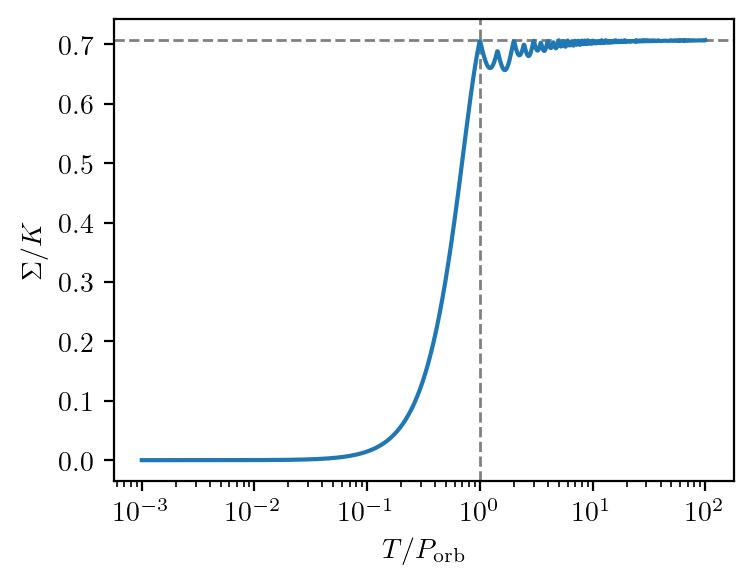

In [5]:
plt.axhline(1/np.sqrt(2), ls='dashed', c='gray', lw=1)
plt.axvline(1, ls='dashed', c='gray', lw=1)
tt = np.logspace(-3, 2, 1000)
plt.semilogx(tt, [f_RMS(_) for _ in tt])
plt.ylabel(r"$\Sigma/K$")
plt.xlabel(r"$T / P_\text{orb}$")
plt.gcf().set_size_inches(4,3)
plt.show()

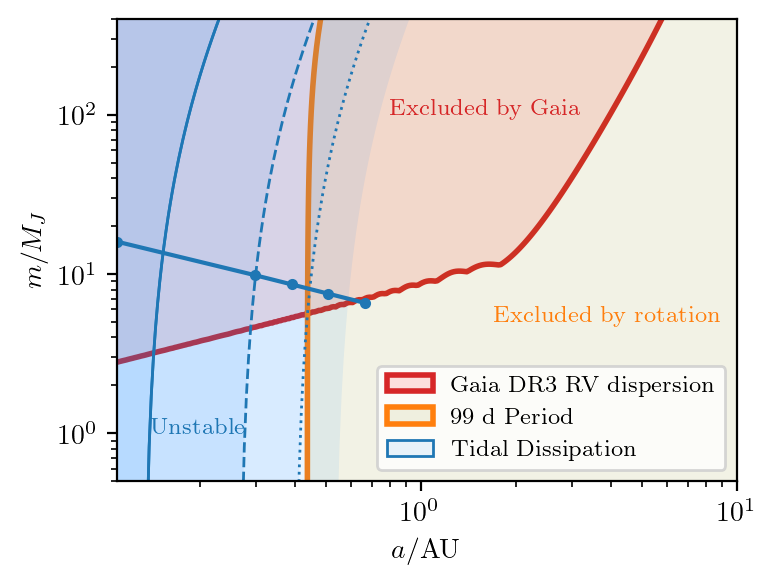

In [6]:
s = slice(None, None)
plt.fill_between(aa.value[s], np.nan_to_num(m2_gaia[s], nan=np.inf),
                     1000, facecolor=(1,0,0,.11), edgecolor='tab:red',
                     lw=2, label=r"Gaia DR3 RV dispersion")


# solve for a at given m2 so that Keplerian orbital period is 99 d
a0 = np.power(c.G * (m1 + mm) / (2 * np.pi / 99 / u.d)**2, 1/3).to(u.au)
plt.fill_betweenx(mm.value, a0.value, 10000,
                  edgecolor='tab:orange', facecolor=(.5,.5,0,.1), lw=2, label=r"99 d Period"
                 )

for i, q in enumerate(roche_q):
    plt.fill_betweenx(
        np.where(np.isnan(q) & (aa.value < 1), 0, (m1 / q).to(u.M_jup).value),
        aa.value,
        facecolor=(0,.5,1,.08), edgecolor="tab:blue",
        lw=1 if not i else 0, label=r"Tidal Dissipation" if i == 0 else None
    )
    plt.plot(aa.value,
             np.where(np.isnan(q) & (aa.value < 1), 0, (m1 / q).to(u.M_jup).value),
             ls={0: 'solid', 1: 'dashed', 2:'dotted'}.get(i, 'none'), c='tab:blue', lw=1
            )
    
plt.plot([0.6658, 0.51, 0.39, 0.298, R.to(u.au).value], [6.59, 7.53, 8.62, 9.86, 16], '.-')

# pyplot logistics

plt.legend(loc='lower right', fontsize='small')
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.xlim(R.to(u.au).value, 1e1)
plt.ylim(.5, 400)
# plt.axvline((23.5 * u.R_sun).to(u.au).value, ls='dashed', c='black')
    
plt.xlabel(r"$a$/AU")
plt.ylabel(r"$m/M_J$")

plt.gcf().set_size_inches(6,3)
plt.savefig(r"rv.svg", bbox_inches='tight', transparent=True)

plt.gcf().set_size_inches(4,3)
plt.text(1.7, 5, "Excluded by rotation", c="tab:orange", fontsize='small')
plt.text(.8, 100, "Excluded by Gaia", c="tab:red", fontsize='small')
plt.text(.14, 1, "Unstable", c="tab:blue", fontsize='small')
plt.savefig(r"rv.pdf", bbox_inches='tight', transparent=True)